In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import sklearn.metrics as metrics
from scipy.stats import norm
from tabulate import tabulate

from iexfinance.stocks import get_historical_data
from iexfinance.stocks import Stock
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
stock_price = pd.read_csv("/content/drive/MyDrive/Algortihmic Trading/NFLX.csv.xls")

In [3]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [9]:
stock_price.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1009.0,4.190597e+02,1.085375e+02,2.339200e+02,3.314900e+02,3.777700e+02,5.091300e+02,6.923500e+02
High,1009.0,4.253207e+02,1.092630e+02,2.506500e+02,3.363000e+02,3.830100e+02,5.156300e+02,7.009900e+02
Low,1009.0,4.123740e+02,1.075559e+02,2.312300e+02,3.260000e+02,3.708800e+02,5.025300e+02,6.860900e+02
Close,1009.0,4.190007e+02,1.082900e+02,2.338800e+02,3.316200e+02,3.786700e+02,5.090800e+02,6.916900e+02
Adj_Close,1009.0,4.190007e+02,1.082900e+02,2.338800e+02,3.316200e+02,3.786700e+02,5.090800e+02,6.916900e+02
Volume,1009.0,7.570685e+06,5.465535e+06,1.144000e+06,4.091900e+06,5.934500e+06,9.322400e+06,5.890430e+07


In [4]:
stock_price.columns = stock_price.columns.str.replace(' ', '_')

In [5]:
stock_price.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [6]:
print('The number of rows (observations) is', stock_price.shape[0], '\n''The number of columns (variables) is', stock_price.shape[1])

The number of rows (observations) is 1009 
The number of columns (variables) is 7


In [7]:
stock_price.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64

In [8]:
stock_price['Date'] = [pd.to_datetime(d) for d in stock_price['Date']]

Text(0.5, 1.0, 'Netflix Stock Price')

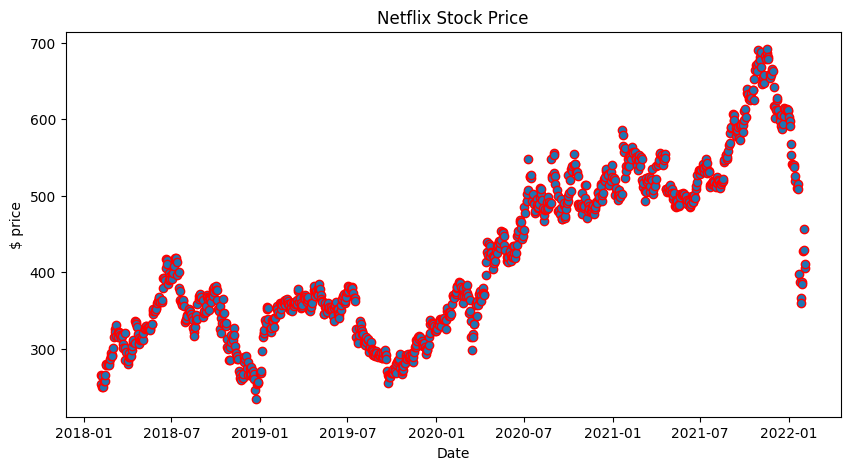

In [10]:
plt.figure(figsize=(10,5))
plt.scatter(stock_price['Date'], stock_price['Adj_Close'], edgecolors='r')
plt.xlabel('Date')
plt.ylabel('$ price')
plt.title('Netflix Stock Price')

## Generating Technical Indicators of the stock

#### Implementing Moving Average

In [11]:
stock_price['average10'] = stock_price['Adj_Close'].rolling(window=10).mean()
stock_price['average20'] = stock_price['Adj_Close'].rolling(window=20).mean()
stock_price['average10'].head(20)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9     262.511998
10    264.940997
11    266.472998
12    267.831000
13    271.413999
14    275.882999
15    279.148996
16    282.459998
17    284.898999
18    286.976999
19    290.625000
Name: average10, dtype: float64

In [12]:
stock_price['std10'] = stock_price['Adj_Close'].rolling(window=10).std()
stock_price['std20'] = stock_price['Adj_Close'].rolling(window=20).std()

#### Computing RSI Indicator
Relative Strength Index (RSI) - The Relative Strength Index (RSI) calculates a ratio of the recent upward price movements to the absolute price movement. The RSI ranges from 0 to 100. The RSI is interpreted as an overbought/oversold indicator when the value is over 70/below 30.

In [13]:
def RSI (data, time_window):
  diff = data.diff(1).dropna()  #Difference in one day

  #Preserve dimensions of diff values
  up_chg = 0 * diff
  down_chg = 0 * diff

  # up change is equal to the positive difference, otherwise equal to 0
  up_chg[diff > 0] = diff[ diff>0 ]

  # down change is equal to the negative difference, otherwise equal to zero
  down_chg[diff < 0] = diff[ diff < 0 ]

  up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
  down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()

  rs = abs(up_chg_avg/down_chg_avg)
  rsi = 100 - 100/(1+rs)
  return rsi

In [14]:
stock_price['rsi5'] = RSI(stock_price['Adj_Close'], 5)
stock_price['rsi14'] = RSI(stock_price['Adj_Close'], 14)

#### Calculating MACD (Moving Average Convergence Divergence)
MACD is the difference between two Exponential Moving Averages

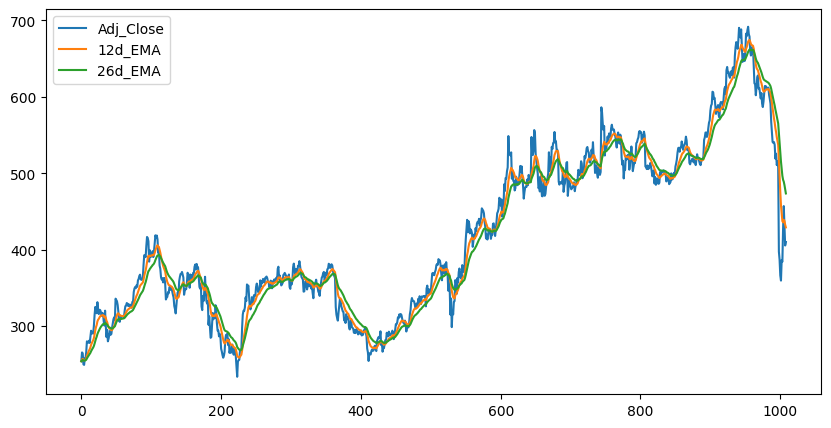

In [15]:
stock_price['12d_EMA'] = stock_price['Adj_Close'].ewm(span=12, adjust=False).mean()
stock_price['26d_EMA'] = stock_price['Adj_Close'].ewm(span=26, adjust=False).mean()

stock_price[['Adj_Close','12d_EMA','26d_EMA']].plot(figsize=(10,5))
plt.show()

#### Calculate the difference between 26 day & 12 day Moving averages

In [17]:
stock_price['macd'] = stock_price['12d_EMA'] - stock_price['26d_EMA']

#### Calculate Signal

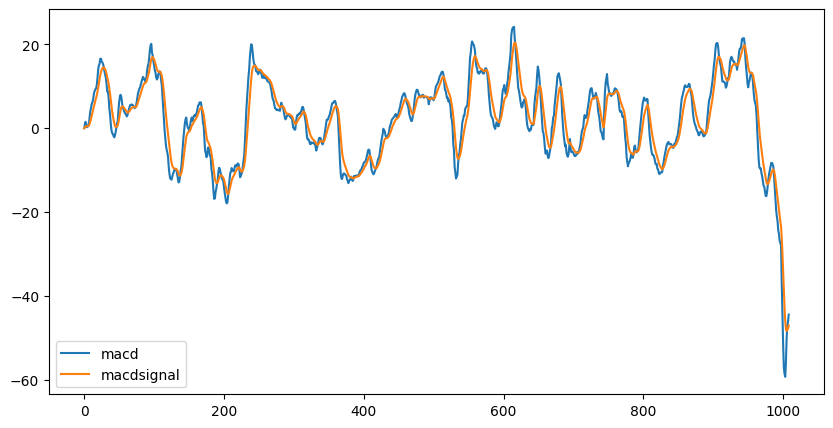

In [18]:
stock_price['macdsignal'] = stock_price.macd.ewm(span=9, adjust=False).mean()

stock_price[['macd','macdsignal']].plot(figsize=(10,5))
plt.show()

#### Compute the Bollinger Bands using the 20-day Moving average

In [19]:
MA = stock_price['Adj_Close'].rolling(window=20).mean()
SD = stock_price['Adj_Close'].rolling(window=20).std()
stock_price['UpperBB'] = MA + (2 * SD)
stock_price['LowerBB'] = MA - (2 * SD)

## Steps: We clean the output and generated a column called direction basis the following:
- If Price > upper Bollinger band, and MACD value > MACD signal -> Buy signal (1)
- If Price < lower Bollinger band, and MACD value < MACD signal -> Sell signal (-1)
- Else, Out of the market -> Signal OOM(0)

In [20]:
# Define Signal
stock_price['Direction'] = np.where((stock_price['macd'] > stock_price['macdsignal']) &
                                      (stock_price['Adj_Close'] > stock_price['UpperBB']), 1,
                                     np.where((stock_price['macd'] < stock_price['macdsignal']) &
                                               (stock_price['Adj_Close'] < stock_price['LowerBB']),-1,0))



stock_price['Direction']

0       0
1       0
2       0
3       0
4       0
       ..
1004    0
1005    0
1006    0
1007    0
1008    0
Name: Direction, Length: 1009, dtype: int64

In [22]:
stock_price['Direction'].value_counts()

 0    905
 1     64
-1     40
Name: Direction, dtype: int64

<Axes: >

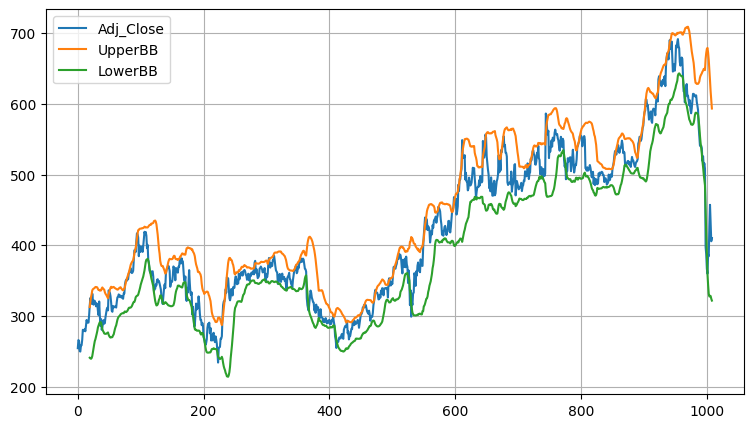

In [23]:
pd.concat([stock_price.Adj_Close,stock_price.UpperBB,stock_price.LowerBB],axis=1).plot(figsize=(9,5),grid=True)

In [24]:
Netflix_Final = stock_price[['Adj_Close','average10', 'average20', 'std10', 'std20', 'rsi5', 'rsi14', 'Direction']]

In [28]:
X = Netflix_Final.drop(['Direction'], axis=1)
y = Netflix_Final['Direction']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=142,stratify=Netflix_Final['Direction'])

Train_netflix = pd.concat([X_train,y_train], axis=1)
Test_netflix = pd.concat([X_test,y_test], axis=1)

#Exporting training & test dataset
Train_netflix.to_csv('Train_netflix.csv',index=False)
Test_netflix.to_csv('Test_netflix.csv',index=False)

#### Importing training & test datasets

In [29]:
Train_netflix = pd.read_csv('Train_netflix.csv')
Test_netflix = pd.read_csv('Test_netflix.csv')

#### Checking frequency of response variables

In [30]:
Netflix_Final['Direction'].value_counts()

 0    905
 1     64
-1     40
Name: Direction, dtype: int64

In [31]:
Train_netflix['Direction'].value_counts()

 0    633
 1     45
-1     28
Name: Direction, dtype: int64

In [32]:
Test_netflix['Direction'].value_counts()

 0    272
 1     19
-1     12
Name: Direction, dtype: int64


# Model building:

We choose to model this data using Decision Trees such as CART & RandomForest. Decision Trees are simple yet powerful and require minimal data preparation such as scaling and missing value treatment etc.Here, Before we proceed for model building, lets do missing value imputation (Scaling is not required while modelling trees)

In [33]:
#creating list of columns in the dataset
col_train=list(Train_netflix)
col_test=list(Test_netflix)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

Train_netflix = pd.DataFrame(imputer.fit_transform(Train_netflix))
Test_netflix = pd.DataFrame(imputer.fit_transform(Test_netflix))

Train_netflix.columns=col_train
Test_netflix.columns=col_test

Train_netflix.head()

,Adj_Close,average10,average20,std10,std20,rsi5,rsi14,Direction
0,490.100006,514.580002,491.550003,18.349255,29.592914,36.450869,51.897863,0.0
1,405.600006,400.118005,464.661999,30.267854,70.212380,40.927668,34.495712,0.0
2,500.489990,521.523993,519.454997,10.834754,12.455477,28.328346,43.753642,0.0
3,606.710022,571.326001,548.538002,19.867412,29.190924,96.824335,85.143919,0.0
4,519.119995,523.819000,512.951500,7.143938,13.313312,49.232732,54.909600,0.0


In [34]:
X_train = Train_netflix.drop(['Direction'], axis=1)
y_train = Train_netflix['Direction']

X_test = Test_netflix.drop(['Direction'], axis=1)
y_test = Test_netflix['Direction']

## Import CART model

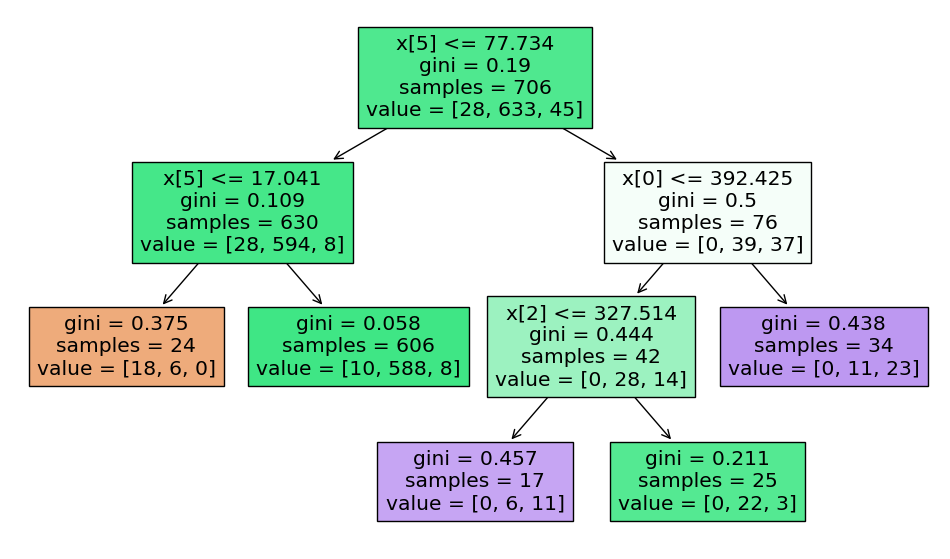

In [35]:
#Visualising Dtree in Python
from sklearn import tree
import matplotlib.pyplot as plt
clf = tree.DecisionTreeClassifier(max_leaf_nodes = 5)
plt.figure(figsize=(12,7))
tree.plot_tree(clf.fit(X_train, y_train),filled=True)
plt.show()

In [36]:
clf = clf.fit(X_train, y_train)

#### Predict on training & test datasets

In [37]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

model_score_train = clf.score(X_train, y_train)
model_score_test = clf.score(X_test, y_test)

##### Confusion matrix report

In [38]:
print(metrics.classification_report(y_train,y_pred_train,digits=3))
print(metrics.classification_report(y_test,y_pred_test,digits=3))

              precision    recall  f1-score   support

        -1.0      0.750     0.643     0.692        28
         0.0      0.967     0.964     0.965       633
         1.0      0.667     0.756     0.708        45

    accuracy                          0.938       706
   macro avg      0.794     0.787     0.789       706
weighted avg      0.939     0.938     0.938       706

              precision    recall  f1-score   support

        -1.0      0.600     0.500     0.545        12
         0.0      0.956     0.952     0.954       272
         1.0      0.591     0.684     0.634        19

    accuracy                          0.917       303
   macro avg      0.716     0.712     0.711       303
weighted avg      0.919     0.917     0.918       303



### Import Random Forest Model

In [39]:
from sklearn.ensemble import RandomForestClassifier
#Create a Gaussian Classifier
clfRF=RandomForestClassifier(n_estimators=100, max_leaf_nodes = 5)

In [40]:
clfRF.fit(X_train,y_train)

RandomForestClassifier(max_leaf_nodes=5)

#### Predict on training & test datasets

In [41]:
y_pred_train = clfRF.predict(X_train)
y_pred_test = clfRF.predict(X_test)

RFmodel_score_train = clfRF.score(X_train, y_train)
RFmodel_score_test = clfRF.score(X_test, y_test)

In [42]:
print(metrics.classification_report(y_train,y_pred_train,digits=3))
print(metrics.classification_report(y_test,y_pred_test,digits=3))

              precision    recall  f1-score   support

        -1.0      1.000     0.214     0.353        28
         0.0      0.906     1.000     0.950       633
         1.0      1.000     0.022     0.043        45

    accuracy                          0.907       706
   macro avg      0.969     0.412     0.449       706
weighted avg      0.915     0.907     0.869       706

              precision    recall  f1-score   support

        -1.0      1.000     0.083     0.154        12
         0.0      0.901     1.000     0.948       272
         1.0      0.000     0.000     0.000        19

    accuracy                          0.901       303
   macro avg      0.634     0.361     0.367       303
weighted avg      0.848     0.901     0.857       303



The Cart model can identiify the OOM signal acccurately and the buy and sell signals somewhat accurately.  

The randomf forest can only identify the OOM signal accurately.

Both models can be improved with further hyperparameter tuning